### Cookbooks Recommendation System (Collaborative, Model Based)

In [2]:
import numpy as np
import pandas as pd
import re, string
import os

#import contractions
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from langdetect import detect
from textblob import TextBlob

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, LatentDirichletAllocation, TruncatedSVD, NMF
from sklearn.cluster import KMeans

from keras.preprocessing import image

from joblib import dump, load
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.image as mpimg
%matplotlib inline

# --- Stopwords
PRINTABLE = [i for i in string.printable]
GENREIC = ["ain't", "aren't", "can't", "can't've", "'cause", "could've", "couldn't", "couldn't've", "didn't", "doesn't", "don't", "hadn't", "hadn't've", "hasn't", "haven't", "he'd", "he'd've", "he'll", "he'll've", "he's", "how'd", "how'd'y", "how'll", "how's", "i'd", "i'd've", "i'll", "i'll've", "i'm", "i've", "isn't", "it'd", "it'd've", "it'll", "it'll've", "it's", "let's", "ma'am", "mayn't", "might've", "mightn't", "mightn't've", "must've", "mustn't", "mustn't've", "needn't", "needn't've", "o'clock", "oughtn't", "oughtn't've", "shan't", "sha'n't", "shan't've", "she'd", "she'd've", "she'll", "she'll've", "she's", "should've", "shouldn't", "shouldn't've", "so've", "so's", "that'd", "that'd've", "that's", "there'd", "there'd've", "there's", "they'd", "they'd've", "they'll", "they'll've", "they're", "they've", "to've", "wasn't", "we'd", "we'd've", "we'll", "we'll've", "we're", "we've", "weren't", "what'll", "what'll've", "what're", "what's", "what've", "when's", "when've", "where'd", "where's", "where've", "who'll", "who'll've", "who's", "who've", "why's", "why've", "will've", "won't", "won't've", "would've", "wouldn't", "wouldn't've", "y'all", "y'all'd", "y'all'd've", "y'all're", "y'all've", "you'd", "you'd've", "you'll", "you'll've", "you're", "you've", "a", "about", "above", "above", "across", "after", "afterwards", "again", "against", "all", "almost", "alone", "along", "already", "also","although","always","am","among", "amongst", "amoungst", "amount",  "an", "and", "another", "any","anyhow","anyone","anything","anyway", "anywhere", "are", "around", "as",  "at", "back","be","became", "because","become","becomes", "becoming", "been", "before", "beforehand", "behind", "being", "below", "beside", "besides", "between", "beyond", "bill", "both", "bottom","but", "by", "call", "can", "cannot", "cant", "co", "con", "could", "couldnt", "cry", "de", "describe", "detail", "do", "done", "down", "due", "during", "each", "eg", "eight", "either", "eleven","else", "elsewhere", "empty", "enough", "etc", "even", "ever", "every", "everyone", "everything", "everywhere", "except", "few", "fifteen", "fify", "fill", "find", "fire", "first", "five", "for", "former", "formerly", "forty", "found", "four", "from", "front", "full", "further", "get", "give", "go", "had", "has", "hasnt", "have", "he", "hence", "her", "here", "hereafter", "hereby", "herein", "hereupon", "hers", "herself", "him", "himself", "his", "how", "however", "hundred", "ie", "if", "in", "inc", "indeed", "interest", "into", "is", "it", "its", "itself", "keep", "last", "latter", "latterly", "least", "less", "ltd", "made", "many", "may", "me", "meanwhile", "might", "mill", "mine", "more", "moreover", "most", "mostly", "move", "much", "must", "my", "myself", "name", "namely", "neither", "never", "nevertheless", "next", "nine", "no", "nobody", "none", "noone", "nor", "not", "nothing", "now", "nowhere", "of", "off", "often", "on", "once", "one", "only", "onto", "or", "other", "others", "otherwise", "our", "ours", "ourselves", "out", "over", "own","part", "per", "perhaps", "please", "put", "rather", "re", "same", "see", "seem", "seemed", "seeming", "seems", "serious", "several", "she", "should", "show", "side", "since", "sincere", "six", "sixty", "so", "some", "somehow", "someone", "something", "sometime", "sometimes", "somewhere", "still", "such", "system", "take", "ten", "than", "that", "the", "their", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "therefore", "therein", "thereupon", "these", "they", "thick", "thin", "third", "this", "those", "though", "three", "through", "throughout", "thru", "thus", "to", "together", "too", "top", "toward", "towards", "twelve", "twenty", "two", "un", "under", "until", "up", "upon", "us", "very", "via", "was", "we", "well", "were", "what", "whatever", "when", "whence", "whenever", "where", "whereafter", "whereas", "whereby", "wherein", "whereupon", "wherever", "whether", "which", "while", "whither", "who", "whoever", "whole", "whom", "whose", "why", "will", "with", "within", "without", "would", "yet", "you", "your", "yours", "yourself", "yourselves", "the"]
SUBJECT_RELATED = ['cookbook', 'cookbooks', 'book', 'books', 'recipes', 'like', 'copyright', 'information']
MISC_STOPWORDS = ['com', 'xa']
ADD_STOPWORDS = ["'caus", "'d", "'ll", "'m", "'re", "'s", "'ve", 'abov', 'afterward', 'ai', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'ca', 'cri', 'describ', 'did', 'doe', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifi', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'inform', 'latterli', 'let', 'mani', 'meanwhil', 'moreov', 'mostli', "n't", 'need', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ought', 'ourselv', 'perhap', 'pleas', 'recip', 'seriou', 'sever', 'sha', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'wo', 'yourselv']
COOKBOOK_STOPWORDS = PRINTABLE + GENREIC + SUBJECT_RELATED + MISC_STOPWORDS + ADD_STOPWORDS

VECTORIZATION = {
    'count': CountVectorizer,
    'tfidf': TfidfVectorizer
}

DIMENSIONALITY_REDUCTION = {
    'PCA': PCA,
    'LSA': TruncatedSVD,
    'NMF': NMF,
    'LDA': LatentDirichletAllocation
}

CLUSTERING = {
    'kmeans': KMeans
}

##########################################################################
# --- Helper Classes
class nlp_model:
    """
    
    #--- Parameters and thier defaults if applicable:
    vect_method = "count"
    dim_reduc="LSA"
    clustering="kmeans"
    n_components = 21
    n_clusters=6
                           
    #--- Attributes:
    self.dataNLP
    self.methods = A dictionary of strings representing pipeline of methods used for NLP model
        example: self.methods is {'Vectorization': 'count',
                                  'Dimensionality Reduction': 'LSA',
                                  'Clustering': 'kmeans'
                                  }                             
    self.objects = A dictionary of objects representing instances of methods used for NLP model
        created as part of the model fit self.fit() method
    self.outputs = A dictionary of primary outputs of pipeline used for NLP model
        created as part of the model fit self.fit() method
    self.n_components = number of components for dimensionality reduction
    self.n_clusters = number of clusters for clustering algorithm (might change with other
                      clustering algorithm inclusions in the future)
    
    #--- Methods:
    
    """
    
    def __init__(self, vect_method = "count", dim_reduc="LSA", clustering="kmeans",
                 n_components = 21, n_clusters=6):
        """
        """
        #self.doc_text = data
        
        ##########################################################################
        #--- Create self.methods attribute from the class parameters
        self.methods = {}
        
        # --- Token Vectorization Methods
        if vect_method == "tfidf":
            self.methods['Vectorization'] = vect_method
        else:
            self.methods['Vectorization'] = "count"
            
        # --- Dimensionality Reduction Methods
        if dim_reduc == "PCA" or dim_reduc == "NMF" or dim_reduc == "LDA":
            self.methods['Dimensionality Reduction'] = dim_reduc
        else:
            self.methods['Dimensionality Reduction'] = "LSA"
        
        # --- Clustering Methods (Only kmeans at the moment. Expand based on need)
        if clustering == "kmeans":
            self.methods['Clustering'] = clustering
        else:
            self.methods['Clustering'] = "kmeans"
        
        ##########################################################################
        # --- number of components for dimensionality reduction
        self.n_components = n_components
        
        # --- number of clusters for clustering
        self.n_clusters = n_clusters
        
    def fit(self, data, save_fit = False, filename = None):
        """
        Function to fit the model using the data from the arguments
        Runs through the pipeline as defined in the object instantiation
        
        Argutments:
        data - nlp data in docs X 1 format, and should be readable by vectorization method
        
        Returns: None object
        """
        ##########################################################################
        # --- Get temp methods, once instantiated will be saved under self.objects
        to_vect = VECTORIZATION[self.methods['Vectorization']]
        to_dim_reduce = DIMENSIONALITY_REDUCTION[self.methods['Dimensionality Reduction']]
        to_cluster = CLUSTERING[self.methods['Clustering']]
        
        ##########################################################################
        self.dataNLP = data
        
        self.objects = {}
        self.outputs = {}
        
        #--- Vectorization step
        self.objects['Vectorization'] =  to_vect(stop_words=COOKBOOK_STOPWORDS, tokenizer=textblob_tokenizer)
        vect_data = self.objects['Vectorization'].fit_transform(self.dataNLP)
        self.outputs['Vectorization'] = vect_data.toarray()
        
        #--- Dimensionality Reduction step
        self.objects['Dimensionality Reduction'] = to_dim_reduce(n_components=self.n_components)
        self.outputs['Dimensionality Reduction'] = self.objects['Dimensionality Reduction'].fit_transform(self.outputs['Vectorization'])
        
        #--- Clustering step
        self.objects['Clustering'] = to_cluster(n_clusters=self.n_clusters, random_state=30)
        self.objects['Clustering'].fit(self.outputs['Dimensionality Reduction'])
        self.outputs['Clustering'] = self.objects['Clustering'].labels_
        
        if save_fit and filename:
            dump(self, filename)
        
        
##########################################################################
# --- Helper Functions

# Use TextBlob
# credit: http://jonathansoma.com/lede/algorithms-2017/classes/more-text-analysis/counting-and-stemming/
def textblob_tokenizer(str_input):
    blob = TextBlob(str_input.lower())
    tokens = blob.words
    words = [token.stem() for token in tokens]
    return words

# --- To plot n-dimensional data 
def plot_all_dimensions(data, class_labels, title=""):
    
    plt.rcParams['figure.figsize'] = [30, 20]
    
    dims = data.shape[1]
    assert dims <= 6
    
    count = 1
    for dim in range(dims):
        i = dim
        j = (i+1) * int(dim != dims-1)
        
        plt.subplot(2,3, count)
        plt.scatter(data[:,i], data[:,j],# ckbk_space[vect][dr][:,2],
                   s = 4, alpha = 0.5, c=class_labels)
        plt.title(title, fontsize=20, color='red')
        count += 1
    plt.show()
    
    
# --- Parser for reading in the Amazon json files (can be used for both reviews and metadata)
# --- credits folloing parse() method to Julian McAuley UCSD: http://jmcauley.ucsd.edu/data/amazon/ 
def parse(path):
    g = open(path, 'r')
    for l in g:
        yield json.loads(l)
        

Using TensorFlow backend.


In [3]:
ckbk_meta_file = "../data/amzn/meta_Cookbooks.json"
ckbk_reviews_file = "../data/amzn/Cookbooks.json"

ckbks = pd.read_json(ckbk_meta_file, lines=True)
print(ckbks.columns)
ckbks.drop(['also_buy', 'brand', 'rank', 'also_view', 'main_cat', 'price', 'image', 'feature', 'date',
       'similar_item', 'details'], axis=1, inplace=True)

#######################################################################################
# --- Cleaning and tokenizing titles and descriptions
alphanumeric = lambda x: re.sub('[\d]+', ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

# --- Lowercase/remove numbers & punctuations/remove stop-words
ckbks['desc_clean'] = ckbks['description'].apply(lambda x: " ".join(str(x).strip().split()))
ckbks['desc_clean'] = ckbks['desc_clean'].map(punc_lower)
ckbks['desc_clean'] = ckbks['desc_clean'].map(alphanumeric)
ckbks['desc_count'] = ckbks['desc_clean'].apply(lambda x: len(list(x.strip().split())))
#ckbks['desc_clean'] = ckbks['desc_clean'].map(alphanumeric) 
#<==== No need to remove stopwords as this step is done in the sklearn token vectorization step

ckbks['title_clean'] = ckbks['title'].apply(lambda x: " ".join(str(x).strip().split()))
ckbks['title_clean'] = ckbks['title_clean'].map(punc_lower)
ckbks['title_clean'] = ckbks['title_clean'].map(alphanumeric)
ckbks['title_count'] = ckbks['title_clean'].apply(lambda x: len(list(x.strip().split())))
#ckbks['desc_clean'] = ckbks['desc_clean'].map(alphanumeric) 
#<==== No need to remove stopwords as this step is done in the sklearn token vectorization step

#ckbks['lang']=ckbks['description'].apply(lambda x: detect(x) if (len(" ".join(str(x).strip().split())) > 5) else "NKnown")

data = ckbks[["asin", "title", "title_clean", "title_count", "description", "desc_clean", "desc_count"]].copy()
data['title_ok']=data['title_count'].apply(lambda x: 1 if (x < 50) else 0)
data['desc_ok']=data['desc_count'].apply(lambda x: 1 if (x>=5 and x < 5000) else 0)
data['use_these']=data['desc_ok']*data['title_ok']
#data
#data[data['title_count']>50]
#indx_to_drop = data[data['title_count']>50].index
#data.drop(indx_to_drop, inplace=True)
#data[data['desc_count']>5000]#.value_counts(bins=10)
data[data['use_these']==1]

Index(['category', 'description', 'title', 'also_buy', 'brand', 'rank',
       'also_view', 'main_cat', 'price', 'asin', 'image', 'feature', 'date',
       'similar_item', 'details'],
      dtype='object')


asin                                              title  \
0      0002154129  France: The Beautiful Cookbook- Authentic Reci...   
1      0002154463  Italy, The Beautiful Cookbook: Authentic Recip...   
2      0002159317  California, The Beautiful Cookbook: Authentic ...   
3      000215854X                    America: The Beautiful Cookbook   
4      000215949X  Mexico The Beautiful Cookbook: Authentic Recip...   
...           ...                                                ...   
44831  B01FMW2MZ6    Joy Fit Club: Cookbook, Diet Plan & Inspiration   
44832  B01FMVXYF4            Drinking in America: Our Secret History   
44833  B01FUPYP0A  Entertaining with Vegetables: A Recipe Collect...   
44834  B01FV1VJ66      Grit Guide to Cast Iron Cooking Magazine 2016   
44835  B01GDAS296  Liberation Soup and Other Recipes from Microen...   

                                             title_clean  title_count  \
0      france  the beautiful cookbook  authentic reci...           11   
1      italy  the beautiful cookbook  authentic recip...           11   
2      california  the beautiful cookbook  authentic ...            8   
3                        america  the beautiful cookbook            4   
4      mexico the beautiful cookbook  authentic recip...           11   
...                                                  ...          ...   
44831    joy fit club  cookbook  diet plan   inspiration            7   
44832            drinking in america  our secret history            6   
44833  entertaining with vegetables  a recipe collect...           17   
44834         grit guide to cast iron cooking magazine              7   
44835  liberation soup and other recipes from microen...           10   

                                             description  \
0      [Though at first glance too luscious for the p...   
1      [Lorenza de Medici has published more than 30 ...   
2      [Two collections of California's best. The lat...   
3      [Fifth in the series that includes the best-se...   
4      [The latest addition to this popular series is...   
...                                                  ...   
44831  [Recipe Excerpts from The Joy Fit Club      Ch...   
44832  ["A fascinating look at the place and function...   
44833  [ALL NEW 5th Edition to kick off 2017 with exp...   
44834  [Grit Country Series Magazine 2016  (Volume 10...   
44835  [The Whole Planet Foundation cookbook was insp...   

                                              desc_clean  desc_count  \
0        though at first glance too luscious for the ...         258   
1        lorenza de medici has published more than   ...         520   
2        two collections of california  s best  the l...         165   
3        fifth in the series that includes the best s...          92   
4        the latest addition to this popular series i...         167   
...                                                  ...         ...   
44831    recipe excerpts from the joy fit club chicke...         362   
44832     a fascinating look at the place and functio...         556   
44833    all new  th edition to kick off   with expan...          94   
44834    grit country series magazine    volume    no...          70   
44835    the whole planet foundation cookbook was ins...          74   

       title_ok  desc_ok  use_these  
0             1        1          1  
1             1        1          1  
2             1        1          1  
3             1        1          1  
4             1        1          1  
...         ...      ...        ...  
44831         1        1          1  
44832         1        1          1  
44833         1        1          1  
44834         1        1          1  
44835         1        1          1  

[29929 rows x 10 columns]

In [4]:
ckbks_avg_ratings = "../data/amzn/cookbook_ratings.csv"
ratings_dict = json.loads(open(ckbks_avg_ratings).read())
print(len(ratings_dict))
data["avg_ratings"] = data['asin'].apply(lambda x: ratings_dict[x]["avg_rating"] if x in ratings_dict else 0)

15782


In [5]:
data[ (data['use_these']==1) * (data["avg_ratings"]>0)]

covers_loc = "../data/amzn/covers/"
asins_with_covers = [f for f in os.listdir(covers_loc) if os.path.isfile(os.path.join(covers_loc, f)) and ".jpg" in f]

//anaconda3/envs/metis/lib/python3.7/site-packages/pandas/core/computation/expressions.py:194: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]


In [6]:
data['wpics'] = data['asin'].apply(lambda x: 1 if str(x+".jpg") in asins_with_covers else 0)
data

asin                                              title  \
0      0002154129  France: The Beautiful Cookbook- Authentic Reci...   
1      0002154463  Italy, The Beautiful Cookbook: Authentic Recip...   
2      0002159317  California, The Beautiful Cookbook: Authentic ...   
3      000215854X                    America: The Beautiful Cookbook   
4      000215949X  Mexico The Beautiful Cookbook: Authentic Recip...   
...           ...                                                ...   
44831  B01FMW2MZ6    Joy Fit Club: Cookbook, Diet Plan & Inspiration   
44832  B01FMVXYF4            Drinking in America: Our Secret History   
44833  B01FUPYP0A  Entertaining with Vegetables: A Recipe Collect...   
44834  B01FV1VJ66      Grit Guide to Cast Iron Cooking Magazine 2016   
44835  B01GDAS296  Liberation Soup and Other Recipes from Microen...   

                                             title_clean  title_count  \
0      france  the beautiful cookbook  authentic reci...           11   
1      italy  the beautiful cookbook  authentic recip...           11   
2      california  the beautiful cookbook  authentic ...            8   
3                        america  the beautiful cookbook            4   
4      mexico the beautiful cookbook  authentic recip...           11   
...                                                  ...          ...   
44831    joy fit club  cookbook  diet plan   inspiration            7   
44832            drinking in america  our secret history            6   
44833  entertaining with vegetables  a recipe collect...           17   
44834         grit guide to cast iron cooking magazine              7   
44835  liberation soup and other recipes from microen...           10   

                                             description  \
0      [Though at first glance too luscious for the p...   
1      [Lorenza de Medici has published more than 30 ...   
2      [Two collections of California's best. The lat...   
3      [Fifth in the series that includes the best-se...   
4      [The latest addition to this popular series is...   
...                                                  ...   
44831  [Recipe Excerpts from The Joy Fit Club      Ch...   
44832  ["A fascinating look at the place and function...   
44833  [ALL NEW 5th Edition to kick off 2017 with exp...   
44834  [Grit Country Series Magazine 2016  (Volume 10...   
44835  [The Whole Planet Foundation cookbook was insp...   

                                              desc_clean  desc_count  \
0        though at first glance too luscious for the ...         258   
1        lorenza de medici has published more than   ...         520   
2        two collections of california  s best  the l...         165   
3        fifth in the series that includes the best s...          92   
4        the latest addition to this popular series i...         167   
...                                                  ...         ...   
44831    recipe excerpts from the joy fit club chicke...         362   
44832     a fascinating look at the place and functio...         556   
44833    all new  th edition to kick off   with expan...          94   
44834    grit country series magazine    volume    no...          70   
44835    the whole planet foundation cookbook was ins...          74   

       title_ok  desc_ok  use_these  avg_ratings  wpics  
0             1        1          1     4.863636      1  
1             1        1          1     4.538462      1  
2             1        1          1     5.000000      1  
3             1        1          1     0.000000      1  
4             1        1          1     4.535714      1  
...         ...      ...        ...          ...    ...  
44831         1        1          1     0.000000      0  
44832         1        1          1     0.000000      0  
44833         1        1          1     0.000000      0  
44834         1        1          1     0.000000      0  
44835         1        1          1     0.00000

In [7]:
def getOneImageArray(filePath, target_size=(224, 224)):
        
        img = image.load_img(filePath, target_size)
        #x = image.img_to_array(img, target_size=(224, 224))
        #x = np.expand_dims(x, axis=0)
        #print(x.shape)
        return img

def plotCookbooks(asins, showMissing = False):
    check_asins = []
    covers_loc = "../data/amzn/covers/"
    
    no_of_images = len(asins)
    row_images = 1 + (no_of_images-1)//5
    image_size = (256, 256)
    
    plt.rcParams['figure.figsize'] = [20, 20]
    #plt.figure(figsize=(row_images*10,5*10))
    count = 1
    for asin in asins:
        try:
            filePath = covers_loc + str(asin)+".jpg"
            img = image.load_img(filePath, target_size=image_size)
        except:
            img = np.ones((image_size[0], image_size[1], 3))
        plt.subplot(row_images, 5, count)
        plt.axis("off")
        plt.imshow(img)
        count += 1
    plt.axis("off")
    plt.subplots_adjust(hspace=0, wspace=0)
    plt.show();
    

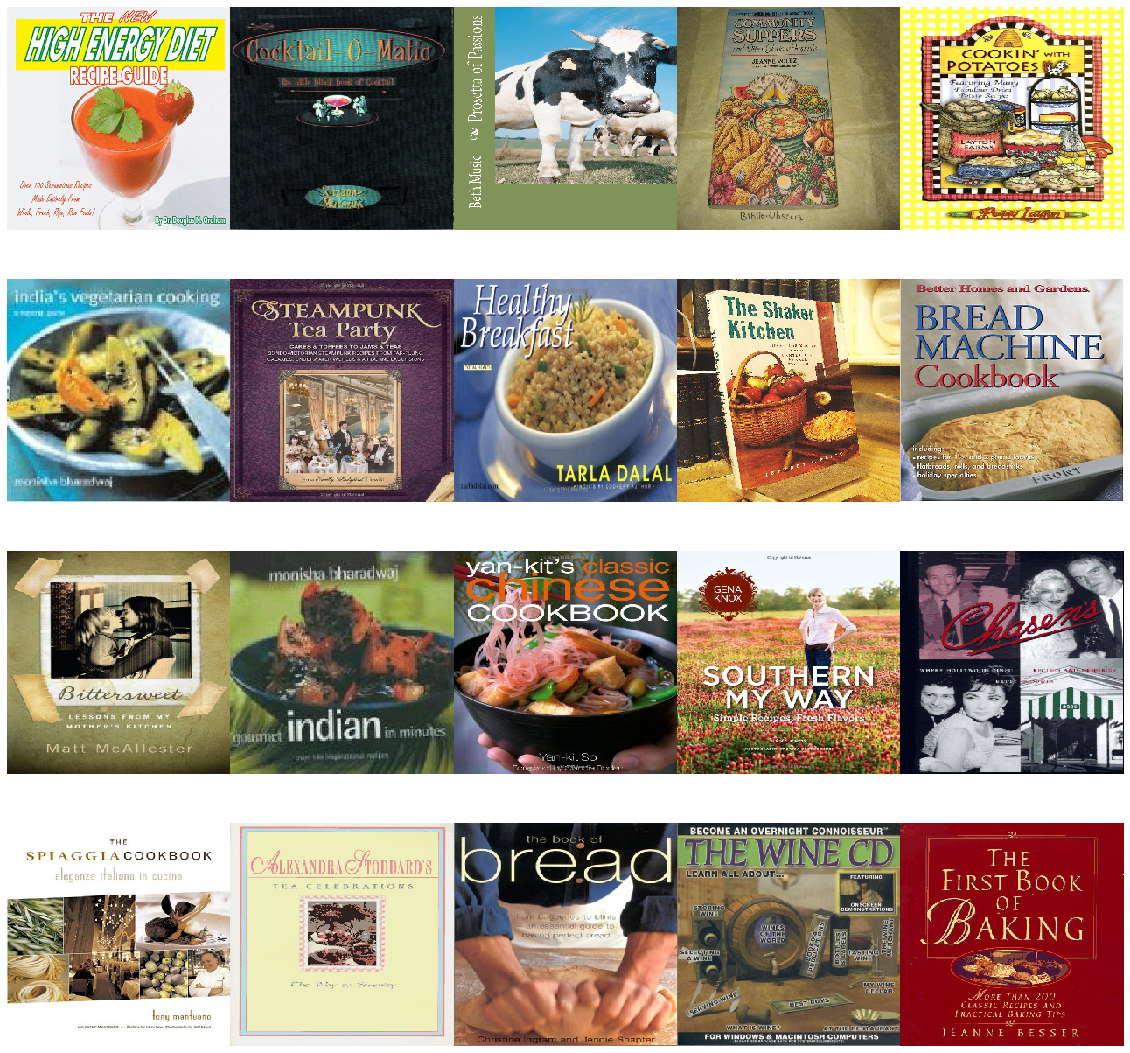

In [8]:
list_asins = np.array(data[data['wpics']==1].sample(20)['asin'])
plotCookbooks(list_asins)

In [61]:
import random

import pandas as pd
from surprise import SVD
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate, train_test_split
from surprise import accuracy

ratings_matrix_file = "../data/amzn/ratings_matrix.csv"
book_ids_file = "../data/amzn/ratings_matrix_bookIDs.json"
user_ids_file = "../data/amzn/ratings_matrix_reviwerIDs.json"

books_ASIN = json.loads(open(book_ids_file).read()) #asin to idx lookup
reviewer_ID = json.loads(open(user_ids_file).read()) #reviewerID to idx lookup

review_reader = Reader(line_format="item user rating", sep=",")
cookbook_ratings = Dataset.load_from_file(ratings_matrix_file, reader = review_reader)

print(f"Number of books with reviews: {len(books_ASIN)}")
print(f"Number of users: {len(reviewer_ID)}")

raw_ratings = cookbook_ratings.raw_ratings
random.shuffle(raw_ratings)

# A = 90% of the data, B = 10% of the data
threshold = int(.9 * len(raw_ratings))
A_raw_ratings = raw_ratings[:threshold]
B_raw_ratings = raw_ratings[threshold:]
alldataset = cookbook_ratings.build_full_trainset()

cookbook_ratings.raw_ratings = A_raw_ratings  # data is now the set A

params = {'n_factors': 20, 'biased': True, 'lr_all': 0.005, 
          'reg_all': 0.16, 'random_state': 333, 'verbose': True
         }

trainset = cookbook_ratings.build_full_trainset()
reco_cookbooks = SVD(**params)
reco_cookbooks.fit(trainset)

# Compute biased accuracy on A
predictionsA = reco_cookbooks.test(trainset.build_testset())
print('Biased accuracy on A,', end='   ')
accuracy.rmse(predictionsA)

# Compute unbiased accuracy on B
testset = cookbook_ratings.construct_testset(B_raw_ratings)  # testset is now the set B
predictionsB = reco_cookbooks.test(testset)
print('Unbiased accuracy on B,', end=' ')
accuracy.rmse(predictionsB)

Number of books with reviews: 15782
Number of users: 210808
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Biased accuracy on A,   RMSE: 0.8073
Unbiased accuracy on B, RMSE: 0.9298


0.9297861162320074

In [62]:
print('Biased accuracy on A,', end='   ')
accuracy.mae(predictionsA)
print('Unbiased accuracy on B,', end=' ')
accuracy.mae(predictionsB)

Biased accuracy on A,   MAE:  0.5882
Unbiased accuracy on B, MAE:  0.6755


0.6754814651928418

In [11]:
raw_uid = [trainset.to_raw_uid(k) for k in trainset.ur.keys()]
print(raw_uid)

['38106', '31639', '16708', '27020', '4357', '11367', '23534', '26021', '31758', '7332', '242', '30568', '98290', '68397', '2821', '193252', '83214', '82536', '124673', '17511', '191684', '7588', '5653', '106111', '195943', '109955', '83923', '76718', '2723', '31188', '19517', '67012', '144885', '39306', '67379', '84494', '161608', '137203', '110626', '1227', '129634', '114191', '40106', '17548', '197683', '36387', '195901', '153797', '58999', '160427', '119705', '55017', '84514', '45651', '116531', '187972', '48196', '8548', '14685', '46320', '46113', '106217', '177875', '112145', '5283', '5016', '110646', '118124', '4390', '83748', '151861', '190210', '26870', '11187', '85877', '175900', '9792', '64282', '162586', '76199', '99443', '31168', '17415', '39391', '11711', '12033', '11294', '2617', '48678', '143987', '84025', '165663', '15589', '194663', '89892', '167438', '5522', '20019', '139959', '128016', '44125', '161093', '82883', '13112', '80176', '139158', '90402', '1730', '1921', 

In [12]:
print(f"Total number of users are: {trainset.n_users}")
print(f"Total number of books are: {trainset.n_items}")
trainset.rating_scale

Total number of users are: 210808
Total number of books are: 15782


(1, 5)

In [48]:
pred = reco_cookbooks.predict(2000,759, verbose=True)
pred = reco_cookbooks.predict(7528,127557, verbose=True)
#print(trainset.to_inner_uid(127557))
#print(trainset.to_inner_iid(7528))

user: 2000       item: 759        r_ui = None   est = 4.45   {'was_impossible': False}
user: 7528       item: 127557     r_ui = None   est = 4.45   {'was_impossible': False}


In [13]:
#𝑟̂𝑢𝑖=𝜇+𝑏𝑢+𝑏𝑖+𝑞𝑇𝑖𝑝𝑢
bu = reco_cookbooks.bu
bi = reco_cookbooks.bi
qi = reco_cookbooks.qi
pu = reco_cookbooks.pu

In [14]:
print(f"Shape of bu: {bu.shape}")
print(f"Shape of bi: {bi.shape}")
print(f"Shape of qi: {qi.shape}")
print(f"Shape of pu: {pu.shape}")

Shape of bu: (210808,)
Shape of bi: (15782,)
Shape of qi: (15782, 20)
Shape of pu: (210808, 20)


In [18]:
reco_model = (bu, bi, qi, pu)
from joblib import load, dump

dump(reco_model, "../model/reco_model.joblib")

['../model/reco_model.joblib']

In [35]:
#data[(data['title_ok']==1) * (data['desc_ok']==1) * (data['avg_ratings']>0)]['wpics']
data[(data['avg_ratings']>1) * (data['avg_ratings']<2)]

asin                                              title  \
17351  0967838258                           The New Armenian Kitchen   
18303  0981538185  Sensa Weight-Loss Program: The Accidental Disc...   
26903  1519610998  Cooking For One Cookbook: Loaded With Deliciou...   
35355  1624144675  Alternative Vegan: Healthy Plant-Based Recipes...   

                                             title_clean  title_count  \
17351                           the new armenian kitchen            4   
18303  sensa weight loss program  the accidental disc...           15   
26903  cooking for one cookbook  loaded with deliciou...           18   
35355  alternative vegan  healthy plant based recipes...           10   

                                             description  \
17351  [I put together "The New Armenian Kitchen" and...   
18303  [Hirsch, a neurologist and psychiatrist, is th...   
26903                                               [, ]   
35355  [, Alternative Vegan is the cookbook youve bee...   

                                              desc_clean  desc_count  \
17351    i put together  the new armenian kitchen  an...         318   
18303    hirsch  a neurologist and psychiatrist  is t...          18   
26903                                                              0   
35355        alternative vegan is the cookbook youve ...         174   

       title_ok  desc_ok  use_these  avg_ratings  wpics  
17351         1        1          1     1.833333      1  
18303         1        1          1     1.916667      1  
26903         1        0          0     1.800000      0  
35355         1        1          1     1.875000      0

In [36]:
books_ASIN['1624144675']

11056

In [82]:
# ---
inner2raw_uid = {k:trainset.to_raw_uid(k) for k in trainset.all_users()}
raw2inner_uid = {v:k for k,v in inner2raw_uid.items()}
# ---
inner2raw_iid = {k:trainset.to_raw_iid(k) for k in trainset.all_items()}
raw2inner_iid = {v:k for k,v in inner2raw_iid.items()}
print(raw_uid)

['38106', '31639', '16708', '27020', '4357', '11367', '23534', '26021', '31758', '7332', '242', '30568', '98290', '68397', '2821', '193252', '83214', '82536', '124673', '17511', '191684', '7588', '5653', '106111', '195943', '109955', '83923', '76718', '2723', '31188', '19517', '67012', '144885', '39306', '67379', '84494', '161608', '137203', '110626', '1227', '129634', '114191', '40106', '17548', '197683', '36387', '195901', '153797', '58999', '160427', '119705', '55017', '84514', '45651', '116531', '187972', '48196', '8548', '14685', '46320', '46113', '106217', '177875', '112145', '5283', '5016', '110646', '118124', '4390', '83748', '151861', '190210', '26870', '11187', '85877', '175900', '9792', '64282', '162586', '76199', '99443', '31168', '17415', '39391', '11711', '12033', '11294', '2617', '48678', '143987', '84025', '165663', '15589', '194663', '89892', '167438', '5522', '20019', '139959', '128016', '44125', '161093', '82883', '13112', '80176', '139158', '90402', '1730', '1921', 

In [79]:
reco_model = {'bu': bu,
              'bi':bi,
              'qi':qi,
              'pu': pu,
              'inner2raw_uid': inner2raw_uid,
              'raw2inner_uid': raw2inner_uid,
              'inner2raw_iid': inner2raw_iid,
              'raw2inner_iid': raw2inner_iid
             }
from joblib import load, dump

dump(reco_model, "../model/reco_model.joblib")

['../model/reco_model.joblib']

In [40]:
print(qi.shape)

(15782, 20)


In [83]:
class reco_cookbooks_model:
    def __init__(self, reco_model):
        self.bu = reco_model['bu']
        self.bi = reco_model['bi']
        self.pu = reco_model['pu']
        self.qi = reco_model['qi']
        
        self.inner2raw_uid = reco_model['inner2raw_uid']
        self.raw2inner_uid = reco_model['raw2inner_uid']
        self.inner2raw_iid = reco_model['inner2raw_iid']
        self.raw2inner_iid = reco_model['raw2inner_iid']
    
    def predict_top10(self, raw_userid, raw_itemid):
        inner_uid = self.raw2inner_uid[str(raw_userid)]
        inner_iid = self.raw2inner_iid[str(raw_itemid)]
        
        temp_pu = self.pu[inner_uid].reshape(1, -1)
        temp_bu = self.bu[inner_uid]
        #temp_bi = self.bi
        #temp_qi = self.qi
        print(temp_bu.shape)
        print(qi.T.shape)
        print(self.bi.shape)
        print(temp_bu.shape)
        
        step1 = np.matmul(temp_pu, self.qi.T)
        step2 = np.add(step1, temp_bu)
        step3 = np.add(step2, self.bi.reshape(-1, 1))
        
        return step3[inner_iid]

test = reco_cookbooks_model(reco_model)
print(test.predict_top10('51245', '1850'))
        
        

()
(20, 15782)
(15782,)
()
[-1.19426117 -1.24251492 -1.27234588 ... -1.24708647 -1.28617002
 -1.27935089]


In [1]:
#trainset.to_inner_iid('123211')
pred = reco_cookbooks.predict('83354', '15556', verbose=True)
print(A_raw_ratings[96:180])

NameError: name 'reco_cookbooks' is not defined

In [78]:
dump(reco_cookbooks, "../model/reco_surprise_model.joblib")

['../model/reco_surprise_model.joblib']